### Langraph Workflows + Agents

In [1]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    base_url="http://localhost:12434/engines/v1",
    api_key="docker",
    temperature=0,
    model="ai/gemma3",  # ai/llama3.2
    stream_usage=True
)


In [2]:
# LLMs and augmentations

# Schema for structured output
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )


# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")

In [3]:
output

SearchQuery(search_query='Calcium CT score and high cholesterol relationship', justification='This query directly asks about the connection between calcium CT scores and high cholesterol, a key area of interest for understanding the topic.')

In [4]:
# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'Uc3EF4zvRoU1aSwvYpaqw0JMZF3eVp2t',
  'type': 'tool_call'}]

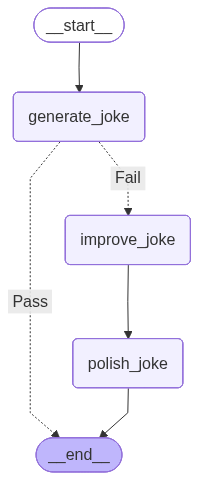

Initial joke:
Why did the cat join the Red Cross? 

Because he wanted to be a first-aid kit! 

---

Would you like to hear another joke?

--- --- ---

Joke failed quality gate - no punchline detected!


In [3]:
# Prompt chaining

# Graph API

from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""
    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

# Invoke
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

In [4]:
# Functional API

from langgraph.func import entrypoint, task


# Tasks
@task
def generate_joke(topic: str):
    """First LLM call to generate initial joke"""
    msg = llm.invoke(f"Write a short joke about {topic}")
    return msg.content


def check_punchline(joke: str):
    """Gate function to check if the joke has a punchline"""
    # Simple check - does the joke contain "?" or "!"
    if "?" in joke or "!" in joke:
        return "Fail"

    return "Pass"


@task
def improve_joke(joke: str):
    """Second LLM call to improve the joke"""
    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {joke}")
    return msg.content


@task
def polish_joke(joke: str):
    """Third LLM call for final polish"""
    msg = llm.invoke(f"Add a surprising twist to this joke: {joke}")
    return msg.content


@entrypoint()
def prompt_chaining_workflow(topic: str):
    original_joke = generate_joke(topic).result()
    if check_punchline(original_joke) == "Pass":
        return original_joke

    improved_joke = improve_joke(original_joke).result()
    return polish_joke(improved_joke).result()

# Invoke
for step in prompt_chaining_workflow.stream("cats", stream_mode="updates"):
    print(step)
    print("\n")

{'generate_joke': 'Why did the cat join the Red Cross? \n\nBecause he wanted to be a first-aid kit! \n\n---\n\nWould you like to hear another joke?'}


{'improve_joke': 'That’s a good one! It’s perfectly fine as is, but let’s punch it up a bit. Here’s a revised version with more wordplay:\n\nWhy did the cat join the Red Cross? \n\nBecause he wanted to be a first-aid *paws*! \n\n---\n\nWould you like to hear another joke?'}


{'polish_joke': 'That’s a cute one! The “paws” pun is a nice touch.\n\nYes, please! Tell me another joke.'}


{'prompt_chaining_workflow': 'That’s a cute one! The “paws” pun is a nice touch.\n\nYes, please! Tell me another joke.'}




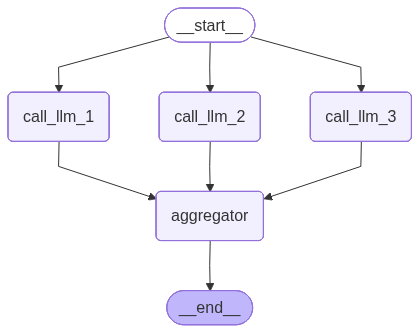

Here's a story, joke, and poem about cats!

STORY:
The rain in Oakhaven always smelled of moss and regret. It clung to the slate roofs and dripped from the ancient oaks that lined the cobblestone streets, a constant, melancholic soundtrack to the town. And in Oakhaven, the soundtrack was always punctuated by the quiet, insistent purrs of the Cat Council.

The Cat Council wasn’t a formal organization, of course. It was simply the collective of cats who ruled Oakhaven, each with a territory and a particular brand of grumpy wisdom. There was Silas, a grizzled ginger tabby who’d seen a century of rain and ruled the bakery with an iron paw. Then there was Luna, a sleek black cat with eyes like polished obsidian, who held sway over the antique shop and possessed an unnerving ability to know exactly what you were thinking. And finally, Pip, a fluffy, perpetually bewildered Persian who was, inexplicably, in charge of the town’s library.

Tonight, the Council was convened in the back room of th

In [5]:
# Parallelization

# Graph API
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

In [6]:
# Functional API

@task
def call_llm_1(topic: str):
    """First LLM call to generate initial joke"""
    msg = llm.invoke(f"Write a joke about {topic}")
    return msg.content


@task
def call_llm_2(topic: str):
    """Second LLM call to generate story"""
    msg = llm.invoke(f"Write a story about {topic}")
    return msg.content


@task
def call_llm_3(topic):
    """Third LLM call to generate poem"""
    msg = llm.invoke(f"Write a poem about {topic}")
    return msg.content


@task
def aggregator(topic, joke, story, poem):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {topic}!\n\n"
    combined += f"STORY:\n{story}\n\n"
    combined += f"JOKE:\n{joke}\n\n"
    combined += f"POEM:\n{poem}"
    return combined


# Build workflow
@entrypoint()
def parallel_workflow(topic: str):
    joke_fut = call_llm_1(topic)
    story_fut = call_llm_2(topic)
    poem_fut = call_llm_3(topic)
    return aggregator(
        topic, joke_fut.result(), story_fut.result(), poem_fut.result()
    ).result()

# Invoke
for step in parallel_workflow.stream("cats", stream_mode="updates"):
    print(step)
    print("\n")

{'call_llm_1': 'Why did the cat join the Red Cross? \n\nBecause he wanted to be a first-aid kit! \n\n---\n\nWould you like to hear another one? 😊'}


{'call_llm_3': "Okay, here's a poem about cats, aiming for a blend of their grace, mystery, and charm:\n\n**Velvet Shadows**\n\nA flicker of fur in the fading light,\nA silent hunter, sleek and bright.\nWith eyes of jade, or amber gold,\nA story whispered, yet untold.\n\nThey stretch and yawn, a languid grace,\nA regal stillness in their space.\nA purring rumble, soft and low,\nA comfort only cats can bestow.\n\nThey stalk the dust motes in the sun,\nA playful pounce, a joyful run.\nA cardboard box, a feathered toy,\nLost in a world of simple joy.\n\nA velvet shadow, quick and free,\nA secret held for you and me.\nIndependent, wise, and deep,\nA feline mystery, secrets to keep.\n\nThey curl up close, a warm embrace,\nA quiet solace, a peaceful space.\nCats, enigmatic, sweet, and true,\nA little magic, just for you. \n\n---\n\nWould you li

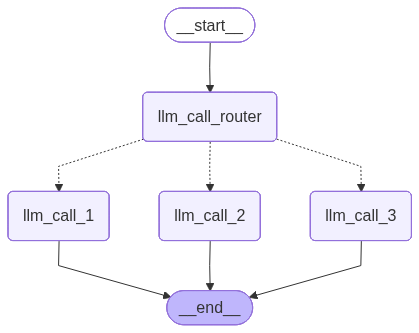

Why did the cat join the Red Cross? 

Because he wanted to be a first-aid kit! 

---

Would you like to hear another one? 😊


In [8]:
# Routing

# Graph API

from typing_extensions import Literal
from langchain.messages import HumanMessage, SystemMessage

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

In [9]:
# Functional API

from typing_extensions import Literal
from pydantic import BaseModel
from langchain.messages import HumanMessage, SystemMessage


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


@task
def llm_call_1(input_: str):
    """Write a story"""
    result = llm.invoke(input_)
    return result.content


@task
def llm_call_2(input_: str):
    """Write a joke"""
    result = llm.invoke(input_)
    return result.content


@task
def llm_call_3(input_: str):
    """Write a poem"""
    result = llm.invoke(input_)
    return result.content


def llm_call_router(input_: str):
    """Route the input to the appropriate node"""
    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=input_),
        ]
    )
    return decision.step


# Create workflow
@entrypoint()
def router_workflow(input_: str):
    next_step = llm_call_router(input_)
    if next_step == "story":
        llm_call = llm_call_1
    elif next_step == "joke":
        llm_call = llm_call_2
    elif next_step == "poem":
        llm_call = llm_call_3

    return llm_call(input_).result()

# Invoke
for step in router_workflow.stream("Write me a joke about cats", stream_mode="updates"):
    print(step)
    print("\n")

{'llm_call_2': 'Why did the cat join the Red Cross? \n\nBecause he wanted to be a first-aid kit! \n\n---\n\nWould you like to hear another one? 😊'}


{'router_workflow': 'Why did the cat join the Red Cross? \n\nBecause he wanted to be a first-aid kit! \n\n---\n\nWould you like to hear another one? 😊'}




In [11]:
# Orchestrator-worker

# Functional API

from typing import List


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)


@task
def orchestrator(topic: str):
    """Orchestrator that generates a plan for the report"""
    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {topic}"),
        ]
    )

    return report_sections.sections


@task
def llm_call(section: Section):
    """Worker writes a section of the report"""

    # Generate section
    result = llm.invoke(
        [
            SystemMessage(content="Write a report section."),
            HumanMessage(
                content=f"Here is the section name: {section.name} and description: {section.description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return result.content


@task
def synthesizer(completed_sections: list[str]):
    """Synthesize full report from sections"""
    final_report = "\n\n---\n\n".join(completed_sections)
    return final_report


@entrypoint()
def orchestrator_worker(topic: str):
    sections = orchestrator(topic).result()
    section_futures = [llm_call(section) for section in sections]
    final_report = synthesizer(
        [section_fut.result() for section_fut in section_futures]
    ).result()
    return final_report

# Invoke
report = orchestrator_worker.invoke("Create a report on LLM scaling laws")
from IPython.display import Markdown
Markdown(report)

KeyboardInterrupt: 

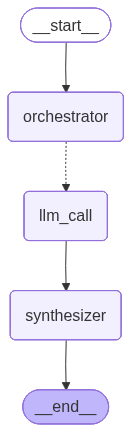

KeyboardInterrupt: 

In [12]:
# Creating workers in LangGraph

from langgraph.types import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])

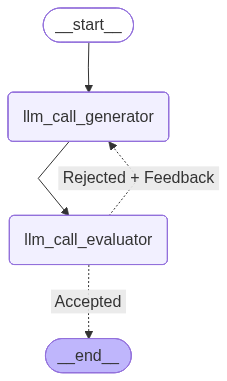

Why did the cat join the Red Cross? 

Because he wanted to be a first-aid kit! 

---

Would you like to hear another one? 😊


In [13]:
# Evaluator-optimizer

# Graph API

# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])

In [14]:
# Functional API

# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
@task
def llm_call_generator(topic: str, feedback: Feedback):
    """LLM generates a joke"""
    if feedback:
        msg = llm.invoke(
            f"Write a joke about {topic} but take into account the feedback: {feedback}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {topic}")
    return msg.content


@task
def llm_call_evaluator(joke: str):
    """LLM evaluates the joke"""
    feedback = evaluator.invoke(f"Grade the joke {joke}")
    return feedback


@entrypoint()
def optimizer_workflow(topic: str):
    feedback = None
    while True:
        joke = llm_call_generator(topic, feedback).result()
        feedback = llm_call_evaluator(joke).result()
        if feedback.grade == "funny":
            break

    return joke

# Invoke
for step in optimizer_workflow.stream("Cats", stream_mode="updates"):
    print(step)
    print("\n")

{'llm_call_generator': 'Why did the cat join the Red Cross? \n\nBecause he wanted to be a first-aid kit! \n\n---\n\nWould you like to hear another one? 😊'}


{'llm_call_evaluator': Feedback(grade='funny', feedback="This is a classic, simple pun! It's a good, lighthearted joke that kids and adults will likely find amusing. It's a solid 7/10 for a good, reliable joke.")}


{'optimizer_workflow': 'Why did the cat join the Red Cross? \n\nBecause he wanted to be a first-aid kit! \n\n---\n\nWould you like to hear another one? 😊'}




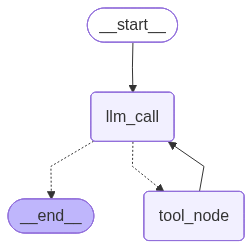

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (gN8BmYr0a5oQtNOUW24EI9seenMZkGjo)
 Call ID: gN8BmYr0a5oQtNOUW24EI9seenMZkGjo
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

7


In [15]:
# Agents

from langchain.tools import tool


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

# Graph API

from langgraph.graph import MessagesState
from langchain.messages import SystemMessage, HumanMessage, ToolMessage


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

In [17]:
# Functional API

from langgraph.graph import add_messages
from langchain.messages import (
    SystemMessage,
    HumanMessage,
    ToolCall,
)
from langchain_core.messages import BaseMessage

@task
def call_llm(messages: list[BaseMessage]):
    """LLM decides whether to call a tool or not"""
    return llm_with_tools.invoke(
        [
            SystemMessage(
                content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
            )
        ]
        + messages
    )


@task
def call_tool(tool_call: ToolCall):
    """Performs the tool call"""
    tool = tools_by_name[tool_call["name"]]
    return tool.invoke(tool_call)


@entrypoint()
def agent(messages: list[BaseMessage]):
    llm_response = call_llm(messages).result()

    while True:
        if not llm_response.tool_calls:
            break

        # Execute tools
        tool_result_futures = [
            call_tool(tool_call) for tool_call in llm_response.tool_calls
        ]
        tool_results = [fut.result() for fut in tool_result_futures]
        messages = add_messages(messages, [llm_response, *tool_results])
        llm_response = call_llm(messages).result()

    messages = add_messages(messages, llm_response)
    return messages

# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
for chunk in agent.stream(messages, stream_mode="updates"):
    print(chunk)
    print("\n")

{'call_llm': AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 578, 'total_tokens': 626, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_provider': 'openai', 'model_name': 'ai/gemma3', 'system_fingerprint': 'b1-ca71fb9', 'id': 'chatcmpl-T8zwsh1i1ervtuiytvH6K8EgilixPF1i', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--cbb967cf-7f75-4b85-9174-4824be3738f0-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 4}, 'id': 'NRe0e681S8Wh0px78SBctTS7J495W5uj', 'type': 'tool_call'}], usage_metadata={'input_tokens': 578, 'output_tokens': 48, 'total_tokens': 626, 'input_token_details': {}, 'output_token_details': {}})}


{'call_tool': ToolMessage(content='7', name='add', id='d346d966-0d48-4af5-9e43-158287c4de15', tool_call_id='NRe0e681S8Wh0px78SBctTS7J495W5uj')}


{'call_llm': AIMessage(content='7', additional_kwargs={'refusal': None}, response_metada